In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from datetime import datetime
import time


import cv2
import pydicom as dicom
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from pydicom import dcmread
from skimage import data, color

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from skimage import morphology
import random

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [2]:
# Import the otsu threshold function
from skimage.filters import threshold_otsu

# Import Gaussian filter
from skimage.filters import gaussian


#read image file
def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d


#Display one image
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

#Display two images    
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True,
    sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

    
#Image scaling   
def imgResize(a1):
    width= a1.shape[1]
    height = a1.shape[0]
    ratio = width / height
    new_height = 32
    new_width=32
    dim=(new_width,new_height)

    #resized_img = resize(a1, dim, anti_aliasing=True)
    resized_img = cv2.resize(a1, dim, interpolation = cv2.INTER_AREA)

    return resized_img

#Gray scale image
def imgGray(a1):
    grayscale=color.rgb2gray(a1)  
    return grayscale



# Removing noise with gaussian filter
def smoothing(a1):
    # Apply filter
    gaussian_image = gaussian(a1, multichannel=True)
    
    return gaussian_image
    # Show original and resulting image to compare
    #plot_comparison(original, gaussian_image, "Blurred with Gaussian filter")
    #show_image(original, "Original")
    #show_image(gaussian_image, "Reduced sharpness Gaussian")


#Thresholding
def thresh_otsu(a1):
    # Obtain the optimal threshold value
    thresh = threshold_otsu(a1)
    # Apply thresholding to the image
    binary_global = (a1 > thresh)
    return binary_global

from skimage.transform import rotate
# Rotate the image 90 degrees clockwise


def vertical_flip(image):
    vertically_flipped = np.flipud(image)
    return vertically_flipped

def horizontal_flip(image):
    horizontally_flipped = np.fliplr(image)
    return horizontally_flipped


def rotate_image(image):
    for i in range(90,271,90):  
        print(i)
        image_rotate = rotate(image, i)
        show_image(image_rotate)
        #return image_rotated

def image_erosion_dilation(image_array):
    
    a1=image_array

    
    # Removing noise with gaussian filter
    gaussian_image=smoothing(image_array)
    
    #Gray scale image
    grayscale=imgGray(gaussian_image)
    
    # Obtain threshold image with  otsu
    binary_global=thresh_otsu(grayscale)

    # Obtain dilated image, using binary dilation
    eroded_image = morphology.binary_erosion(binary_global)
 
    # Obtain dilated image, using binary dilation
    dilated_image = morphology.binary_dilation(eroded_image)

    return dilated_image
 
#Generates brightened images
def augment_brightness(image_array):
    # expand dimension to one sample
    samples = expand_dims(image_array, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    #it = datagen.flow(samples, batch_size=1)
    it = datagen.flow(samples, batch_size=1)
    batch = it.next()
    image = batch[0].astype('uint8')
    return image

#Generates images with standardize
def augment_standardize(image_array):
    samples = expand_dims(image_array, 0)
    datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)   
    datagen.fit(samples)  # fit parameters from data
    it=datagen.flow(samples, batch_size=1)
    batch = it.next()
    image = batch[0].astype('uint8')
    return image

#Generates images with shift
def augment_shift(image_array):
    samples = expand_dims(image_array, 0)
    datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
    datagen.fit(samples) # fit parameters from data
    it=datagen.flow(samples, batch_size=1)
    batch = it.next()   
    image = batch[0].astype('uint8') 
    return image
    

In [3]:
import os
os.chdir('/Users/raj/Data_science/Melanoma_Classification')
df = pd.read_csv('train.csv')

df_count = pd.read_csv('Melanoma_patient_info.csv')
print(df_count.head())

#csv file containing reduced image size information
df_equal=pd.read_csv('Selected_equal_patient.csv')
#df_equal=pd.read_csv('Selected_melanoma_patient_info2N.csv')

print(df_equal.shape)



   Patient_id  Total_image  Melanoma_image  Melanoma_label
0  IP_7279968          115               0               0
1  IP_3075186           24               0               0
2  IP_2842074            5               0               0
3  IP_6890425           22               1               1
4  IP_8723313           20               0               0
(1168, 4)


In [4]:
results=df_equal

In [5]:
results.head()

,Patient_id,image_name,image_label,df_index
0,IP_0962375,ISIC_0149568,1,91
1,IP_8029095,ISIC_0167093,0,158
2,IP_4479736,ISIC_0175530,0,192
3,IP_0135517,ISIC_0188432,1,235
4,IP_0161742,ISIC_0202680,0,297


In [6]:
results.image_label.value_counts()

1    584
0    584
Name: image_label, dtype: int64

In [7]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
import os
os.chdir('/Volumes/RAJ_256/Melanoma1')

Folder_name='Size32/S32_'

Size32/S32_ISIC_0315525.png
(32, 32, 3)


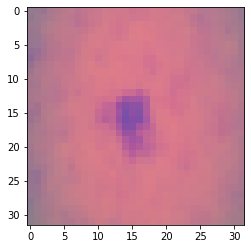

In [9]:
#read randomly selected reduced images (32by32) from patients having mealnoma
image_name=df_equal.image_name[22]
image_path =Folder_name+image_name +'.png'

print(image_path)

import cv2

img = cv2.imread(image_path) 

print(img.shape)
plt.imshow(img)
plt.show()

In [10]:
(X_train,X_test,y_train, y_test)=train_test_split(results.image_name,results.image_label,test_size=0.2,random_state=42)
(X_valid,X_testf,y_valid, y_testf)=train_test_split(X_test, y_test, test_size=0.5,random_state=42)



Size32/S32_ISIC_5191344.png
(32, 32, 3)


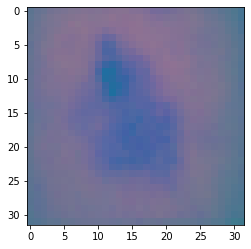

In [11]:
image_name=X_train.iloc[0]
image_path =Folder_name+image_name +'.png'

print(image_path)

import cv2

img = cv2.imread(image_path) 

print(img.shape)
plt.imshow(img)
plt.show()

In [12]:
train_array=[]
train_label=[]


for i in range(len(X_train)):
    image_path =Folder_name+X_train.iloc[i] +'.png'
  
    img = cv2.imread(image_path)
    train_array.append(img)
    train_label.append(y_train.iloc[i])
    
 
valid_array=[]
valid_label=[]

for i in range(len(X_valid)):
    image_path =Folder_name+X_valid.iloc[i] +'.png'
  
    #print(i,X_train.iloc[i],y_train.iloc[i],df[df.image_name==X_train.iloc[i]].target.iloc[0]  )
    img = cv2.imread(image_path)

    valid_array.append(img)
    valid_label.append(y_valid.iloc[i])

  
test_array=[]
test_label=[]

for i in range(len(X_testf)):
    image_path =Folder_name+X_testf.iloc[i] +'.png'
    img = cv2.imread(image_path)

    test_array.append(img)
    
    test_label.append(y_testf.iloc[i])
    
XX_train=np.array(train_array)/255.  #rescaling
XX_valid=np.array(valid_array)/255.
XX_test=np.array(test_array)/255.
    
yy_train=np.array(train_label)
yy_valid=np.array(valid_label)
yy_test=np.array(test_label)

    

In [13]:
print(XX_train.shape)

(934, 32, 32, 3)


In [14]:
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils



batch_size = 4


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')



#model.save_weights('first_try.h5')  # always save your weights after training or during training

    
    

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(XX_train.shape[1], XX_train.shape[1], 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(64, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Activation('relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics = [ 'AUC'])




early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)



#earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01,mode = 'min',patience=2,verbose = 0, restore_best_weights = True)


BS=4
history=model.fit(
        train_datagen.flow(XX_train, yy_train, batch_size=BS),
        epochs=50,
        validation_data=(XX_valid, yy_valid),callbacks=[early_stopping]
        )


model.summary()






Epoch 1/50
234/234 [==============================] - 4s 9ms/step - loss: 0.6991 - auc: 0.5325 - val_loss: 0.6464 - val_auc: 0.7258
Epoch 2/50
234/234 [==============================] - 1s 6ms/step - loss: 0.6886 - auc: 0.5562 - val_loss: 0.6422 - val_auc: 0.7257
Epoch 3/50
234/234 [==============================] - 1s 6ms/step - loss: 0.6611 - auc: 0.6830 - val_loss: 0.6482 - val_auc: 0.7273
Epoch 4/50
234/234 [==============================] - 1s 6ms/step - loss: 0.6442 - auc: 0.6724 - val_loss: 0.6134 - val_auc: 0.7364
Epoch 5/50
234/234 [==============================] - 1s 6ms/step - loss: 0.6598 - auc: 0.6218 - val_loss: 0.6155 - val_auc: 0.7013
Epoch 6/50
234/234 [==============================] - 1s 6ms/step - loss: 0.6441 - auc: 0.6463 - val_loss: 0.5987 - val_auc: 0.7183
Epoch 7/50
234/234 [==============================] - 2s 7ms/step - loss: 0.6053 - auc: 0.7100 - val_loss: 0.6467 - val_auc: 0.7151
Epoch 8/50
234/234 [==============================] - 2s 7ms/step - loss: 0.

<Figure size 432x288 with 0 Axes>

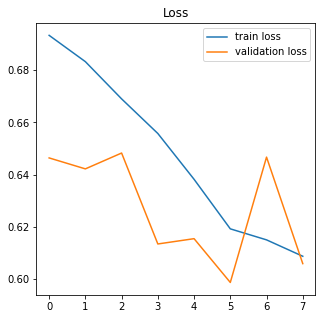

In [18]:
plt.figure(1)
fig = plt.figure(figsize=(5, 5))

# plot loss during training
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()







(117, 1)


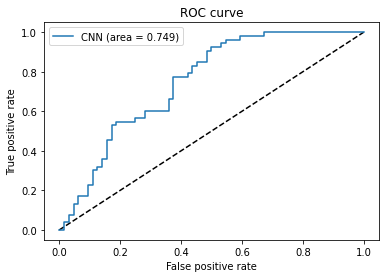

Confusion matrix without normalization
[[31 33]
 [ 4 49]]
 


<Figure size 432x288 with 0 Axes>

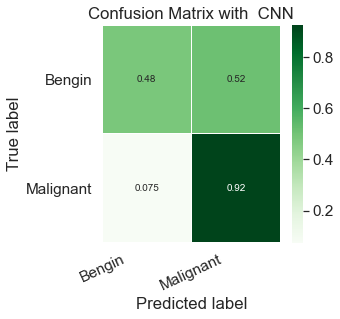

In [19]:
num_classes=2
#Y_valid=yy_test
y_pred_cnn = model.predict(XX_test) 
print(y_pred_cnn.shape)

rounded_predictions=[]
for i in range(len(y_pred_cnn)):
    A=[round(i) for i in y_pred_cnn[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred_cnn)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=yy_test, y_pred=rounded_predictions))




matrix=confusion_matrix(y_true=yy_test, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  CNN')
plt.show()




In [20]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model_augmentC.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model_augmentC.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
from keras.models import model_from_yaml
# load YAML and create model
yaml_file = open('model_augmentC.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_augmentC.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
score = loaded_model.evaluate(XX_test, yy_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]))


auc: 0.75%


In [23]:
Res_XX_train=[]
for i in range(XX_train.shape[0]):
    resized_img = cv2.resize(XX_train[i], (224,224), interpolation = cv2.INTER_AREA)
    Res_XX_train.append(resized_img)

Res_XX_test=[]
for i in range(XX_test.shape[0]):
    resized_img = cv2.resize(XX_test[i], (224,224), interpolation = cv2.INTER_AREA)
    Res_XX_test.append(resized_img)

Res_XX_valid=[]
for i in range(XX_valid.shape[0]):
    resized_img = cv2.resize(XX_valid[i], (224,224), interpolation = cv2.INTER_AREA)
    Res_XX_valid.append(resized_img)
    

In [24]:
Res_XX_train=np.array(Res_XX_train)
Res_XX_valid=np.array(Res_XX_valid)
Res_XX_test=np.array(Res_XX_test)

print(Res_XX_train.shape)
print(Res_XX_valid.shape)
print(Res_XX_test.shape)


(934, 224, 224, 3)
(117, 224, 224, 3)
(117, 224, 224, 3)


In [25]:
from keras.applications.resnet50 import ResNet50

img_rows, img_cols = 224, 224

resnet = ResNet50(weights = 'imagenet',
                      include_top = False,
                      input_shape  =  (img_rows,  img_cols, 3))

for layer in  resnet.layers:
  layer.trainable = False


## lets look at our layers
for (i, layer) in enumerate(resnet.layers):
    print(str(i)  + " "  +  layer.__class__.__name__, layer.trainable)

    


0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


x = resnet.output
x = GlobalAveragePooling2D()(x) #extra layers
#x = (Dense(1000, activation='relu'))(x)
#x = Dropout(0.25)(x)
x = (Dense(256, activation='relu'))(x)
x = Dropout(0.25)(x)
lr = 1e-4
opt = keras.optimizers.Adam(learning_rate=lr)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = resnet.input, outputs = predictions)

model.compile(optimizer = opt ,loss = "binary_crossentropy", metrics=["AUC"]) 
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)


BS=4
history=model.fit(
        train_datagen.flow(Res_XX_train, yy_train, batch_size=BS),
        epochs=50,
        validation_data=(Res_XX_valid, yy_valid),callbacks=[early_stopping]
        )


model.summary()




Epoch 1/50
234/234 [==============================] - 64s 262ms/step - loss: 0.7067 - auc: 0.4710 - val_loss: 0.7053 - val_auc: 0.4767
Epoch 2/50
234/234 [==============================] - 62s 263ms/step - loss: 0.7048 - auc: 0.5121 - val_loss: 0.6923 - val_auc: 0.5091
Epoch 3/50
234/234 [==============================] - 61s 263ms/step - loss: 0.7051 - auc: 0.5025 - val_loss: 0.7122 - val_auc: 0.5000
Epoch 4/50
234/234 [==============================] - 61s 260ms/step - loss: 0.7068 - auc: 0.4943 - val_loss: 0.6981 - val_auc: 0.6199
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230

<Figure size 432x288 with 0 Axes>

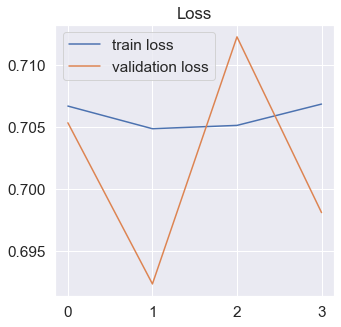

In [35]:
plt.figure(1)
fig = plt.figure(figsize=(5, 5))

# plot loss during training
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()



(117, 1)


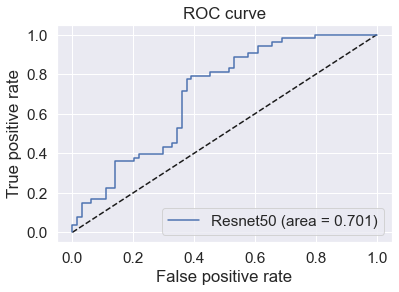

Confusion matrix without normalization
[[ 0 64]
 [ 0 53]]
 


<Figure size 432x288 with 0 Axes>

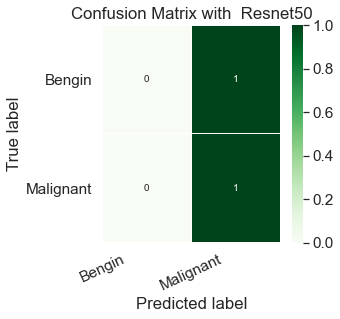

In [36]:
y_pred_cnn = model.predict(Res_XX_test) 
print(y_pred_cnn.shape)

rounded_predictions=[]
for i in range(len(y_pred_cnn)):
    A=[round(i) for i in y_pred_cnn[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred_cnn)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Resnet50 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=yy_test, y_pred=rounded_predictions))


matrix=confusion_matrix(y_true=yy_test, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  Resnet50')
plt.show()



In [42]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def model_inception():
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["AUC"])
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)


model=model_inception()
BS=4

history=model.fit(
        train_datagen.flow(Res_XX_train, yy_train, batch_size=BS),
        epochs=50,
        validation_data=(Res_XX_valid, yy_valid),callbacks=[early_stopping]
        )


#model.summary()



Epoch 1/50
234/234 [==============================] - 47s 187ms/step - loss: 1.0179 - auc: 0.6139 - val_loss: 0.6426 - val_auc: 0.7320
Epoch 2/50
234/234 [==============================] - 45s 191ms/step - loss: 0.6699 - auc: 0.6861 - val_loss: 0.7398 - val_auc: 0.7696
Epoch 3/50
234/234 [==============================] - 48s 205ms/step - loss: 0.6114 - auc: 0.7410 - val_loss: 0.5930 - val_auc: 0.7875
Epoch 4/50
234/234 [==============================] - 44s 190ms/step - loss: 0.6308 - auc: 0.7300 - val_loss: 0.5526 - val_auc: 0.8010
Epoch 5/50
234/234 [==============================] - 45s 191ms/step - loss: 0.6006 - auc: 0.7337 - val_loss: 0.5580 - val_auc: 0.7886
Epoch 6/50
234/234 [==============================] - 45s 190ms/step - loss: 0.5905 - auc: 0.7448 - val_loss: 0.5873 - val_auc: 0.8044


<Figure size 432x288 with 0 Axes>

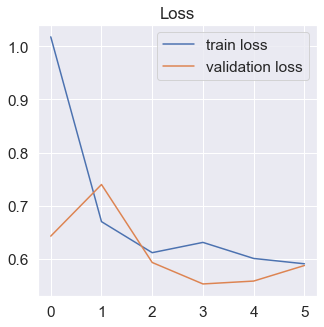

In [43]:
plt.figure(1)
fig = plt.figure(figsize=(5, 5))

# plot loss during training
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

(117, 1)


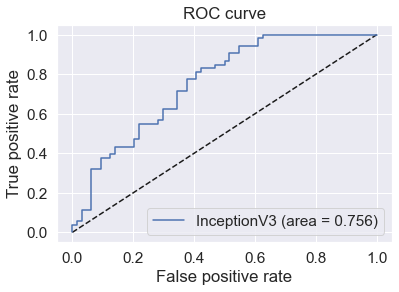

Confusion matrix without normalization
[[55  9]
 [31 22]]
 


<Figure size 432x288 with 0 Axes>

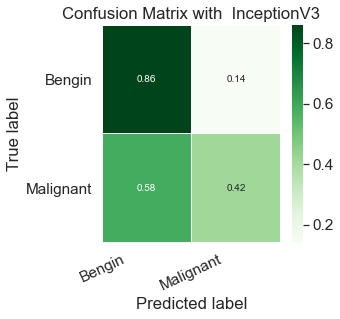

In [44]:
y_pred_cnn = model.predict(Res_XX_test) 
print(y_pred_cnn.shape)

rounded_predictions=[]
for i in range(len(y_pred_cnn)):
    A=[round(i) for i in y_pred_cnn[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred_cnn)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='InceptionV3 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=yy_test, y_pred=rounded_predictions))


matrix=confusion_matrix(y_true=yy_test, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  InceptionV3')
plt.show()




In [45]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D



def model_inception():
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
     # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["AUC"])
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)


model=model_inception()
BS=4

history=model.fit(
        train_datagen.flow(Res_XX_train, yy_train, batch_size=BS),
        epochs=50,
        validation_data=(Res_XX_valid, yy_valid),callbacks=[early_stopping]
        )



Epoch 1/50
234/234 [==============================] - 74s 295ms/step - loss: 0.8778 - auc: 0.5753 - val_loss: 0.5788 - val_auc: 0.7809
Epoch 2/50
234/234 [==============================] - 66s 283ms/step - loss: 0.6318 - auc: 0.7332 - val_loss: 0.5766 - val_auc: 0.7660
Epoch 3/50
234/234 [==============================] - 60s 257ms/step - loss: 0.6251 - auc: 0.7182 - val_loss: 0.6203 - val_auc: 0.7730
Epoch 4/50
234/234 [==============================] - 60s 254ms/step - loss: 0.6032 - auc: 0.7397 - val_loss: 0.5299 - val_auc: 0.8265
Epoch 5/50
234/234 [==============================] - 60s 257ms/step - loss: 0.5884 - auc: 0.7559 - val_loss: 0.6104 - val_auc: 0.7614
Epoch 6/50
234/234 [==============================] - 61s 258ms/step - loss: 0.5966 - auc: 0.7506 - val_loss: 0.5863 - val_auc: 0.8198


<Figure size 432x288 with 0 Axes>

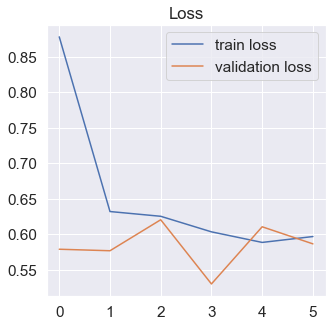

In [46]:
plt.figure(1)
fig = plt.figure(figsize=(5, 5))

# plot loss during training
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

(117, 1)


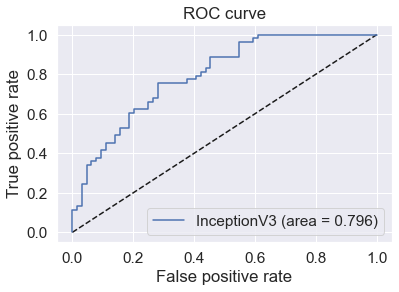

Confusion matrix without normalization
[[35 29]
 [ 6 47]]
 


<Figure size 432x288 with 0 Axes>

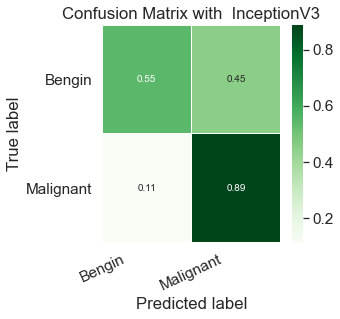

In [47]:
y_pred_cnn = model.predict(Res_XX_test) 
print(y_pred_cnn.shape)

rounded_predictions=[]
for i in range(len(y_pred_cnn)):
    A=[round(i) for i in y_pred_cnn[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred_cnn)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='InceptionV3 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=yy_test, y_pred=rounded_predictions))


matrix=confusion_matrix(y_true=yy_test, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  InceptionV3')
plt.show()





In [48]:
# Importing the important libraries
#from keras.applications.resnet import ResNet152
from keras.applications.vgg19  import VGG19
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [49]:
img_rows, img_cols = 224, 224

def model_VGG19():
    resnet = VGG19(weights = 'imagenet',include_top = False,input_shape  =  (img_rows,  img_cols, 3))

    for layer in  resnet.layers:
      layer.trainable = False


    x = resnet.output
    x = GlobalAveragePooling2D()(x) #extra layers
    x = (Dense(500, activation='relu'))(x)
    x = Dropout(0.25)(x)
    x = (Dense(200, activation='relu'))(x)
    x = Dropout(0.25)(x)
    lr = 1e-4
    opt = keras.optimizers.Adam(learning_rate=lr)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = resnet.input, outputs = predictions)
    model.compile(optimizer = opt ,loss = "binary_crossentropy", metrics=["AUC"]) 
    
    return model

    
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)


BS=4
model=model_VGG19()
history=model.fit(
        train_datagen.flow(Res_XX_train, yy_train, batch_size=BS),
        epochs=50,
        validation_data=(Res_XX_valid, yy_valid),callbacks=[early_stopping]
        )


model.summary()



Epoch 1/50
234/234 [==============================] - 207s 877ms/step - loss: 0.7168 - auc: 0.5016 - val_loss: 0.6862 - val_auc: 0.6557
Epoch 2/50
234/234 [==============================] - 196s 837ms/step - loss: 0.6851 - auc: 0.5829 - val_loss: 0.6717 - val_auc: 0.6667
Epoch 3/50
234/234 [==============================] - 205s 877ms/step - loss: 0.6763 - auc: 0.6044 - val_loss: 0.6793 - val_auc: 0.6708
Epoch 4/50
234/234 [==============================] - 216s 921ms/step - loss: 0.6599 - auc: 0.6463 - val_loss: 0.6572 - val_auc: 0.6827
Epoch 5/50
234/234 [==============================] - 214s 914ms/step - loss: 0.6407 - auc: 0.6867 - val_loss: 0.6577 - val_auc: 0.6865
Epoch 6/50
234/234 [==============================] - 203s 868ms/step - loss: 0.6628 - auc: 0.6152 - val_loss: 0.6452 - val_auc: 0.6984
Epoch 7/50
234/234 [==============================] - 204s 874ms/step - loss: 0.6313 - auc: 0.7003 - val_loss: 0.6576 - val_auc: 0.7026
Epoch 8/50
234/234 [============================

<Figure size 432x288 with 0 Axes>

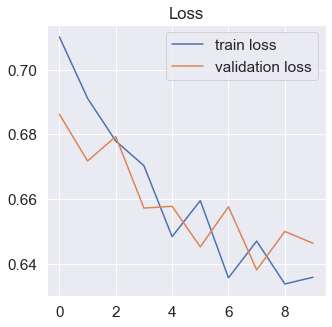

In [50]:
plt.figure(1)
fig = plt.figure(figsize=(5, 5))

# plot loss during training
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

(117, 1)


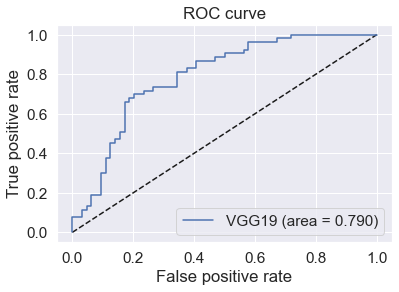

Confusion matrix without normalization
[[35 29]
 [ 7 46]]
 


<Figure size 432x288 with 0 Axes>

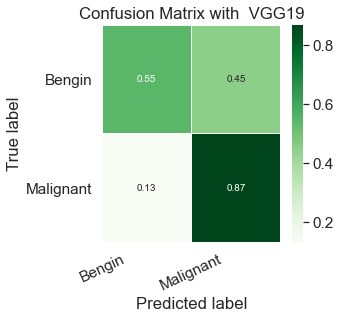

In [51]:
y_pred_cnn = model.predict(Res_XX_test) 
print(y_pred_cnn.shape)

rounded_predictions=[]
for i in range(len(y_pred_cnn)):
    A=[round(i) for i in y_pred_cnn[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred_cnn)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='VGG19 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=yy_test, y_pred=rounded_predictions))


matrix=confusion_matrix(y_true=yy_test, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  VGG19')
plt.show()





In [52]:
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [61]:
def model_efficientNet5():
  
    resnet=EfficientNetB5(input_shape  =  (img_rows,  img_cols, 3), include_top=False, weights='imagenet')
    
    resnet.trainable = False
    
    #for layer in  resnet.layers[:-2]:
    #  layer.trainable = False
    

    x = resnet.output
    x = GlobalAveragePooling2D()(x) #extra layers
    x = (Dense(500, activation='relu'))(x)
    x = Dropout(0.25)(x)
    x = (Dense(200, activation='relu'))(x)
    x = Dropout(0.25)(x)
    lr = 1e-4
    opt = keras.optimizers.Adam(learning_rate=lr)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = resnet.input, outputs = predictions)
    model.compile(optimizer = opt ,loss = "binary_crossentropy", metrics=["AUC"]) 
    
    return model


early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)


BS=64
model=model_efficientNet5()
history=model.fit(
        train_datagen.flow(Res_XX_train, yy_train, batch_size=BS),
        epochs=50,
        validation_data=(Res_XX_valid, yy_valid),callbacks=[early_stopping]
        )


model.summary()




Epoch 1/50
15/15 [==============================] - 158s 10s/step - loss: 0.7022 - auc: 0.4821 - val_loss: 0.6937 - val_auc: 0.5000
Epoch 2/50
15/15 [==============================] - 123s 8s/step - loss: 0.6961 - auc: 0.4842 - val_loss: 0.6937 - val_auc: 0.5000
Epoch 3/50
15/15 [==============================] - 115s 8s/step - loss: 0.6938 - auc: 0.4880 - val_loss: 0.6935 - val_auc: 0.5000
Epoch 4/50
15/15 [==============================] - 115s 8s/step - loss: 0.6951 - auc: 0.4910 - val_loss: 0.6933 - val_auc: 0.5000
Epoch 5/50
15/15 [==============================] - 115s 8s/step - loss: 0.6964 - auc: 0.4702 - val_loss: 0.6926 - val_auc: 0.5000
Epoch 6/50
15/15 [==============================] - 115s 8s/step - loss: 0.6949 - auc: 0.4943 - val_loss: 0.6933 - val_auc: 0.5000
Epoch 7/50
15/15 [==============================] - 116s 8s/step - loss: 0.6950 - auc: 0.4979 - val_loss: 0.6980 - val_auc: 0.4069
Model: "model_11"
________________________________________________________________

(117, 1)


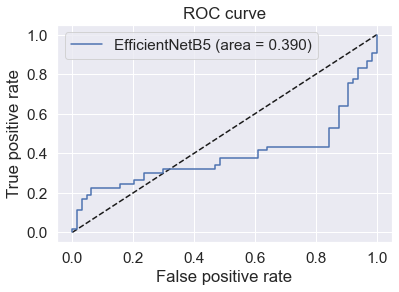

Confusion matrix without normalization
[[ 0 64]
 [ 0 53]]
 


<Figure size 432x288 with 0 Axes>

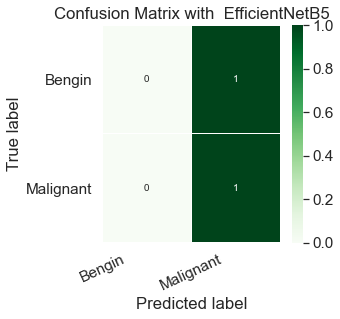

In [63]:
y_pred_cnn = model.predict(Res_XX_test) 
print(y_pred_cnn.shape)

rounded_predictions=[]
for i in range(len(y_pred_cnn)):
    A=[round(i) for i in y_pred_cnn[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred_cnn)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='EfficientNetB5 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=yy_test, y_pred=rounded_predictions))


matrix=confusion_matrix(y_true=yy_test, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  EfficientNetB5')
plt.show()



In [66]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
def model_efficientNet0():
  
    resnet=EfficientNetB0(input_shape  =  (img_rows,  img_cols, 3), include_top=False, weights='imagenet')
    
    resnet.trainable = False
    
    #for layer in  resnet.layers[:-2]:
    #  layer.trainable = False
    

    x = resnet.output
    x = GlobalAveragePooling2D()(x) #extra layers
    x = (Dense(500, activation='relu'))(x)
    x = Dropout(0.25)(x)
    x = (Dense(200, activation='relu'))(x)
    x = Dropout(0.25)(x)
    lr = 1e-4
    opt = keras.optimizers.Adam(learning_rate=lr)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = resnet.input, outputs = predictions)
    model.compile(optimizer = opt ,loss = "binary_crossentropy", metrics=["AUC"]) 
    
    return model


early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)


BS=4
model=model_efficientNet0()
history=model.fit(
        train_datagen.flow(Res_XX_train, yy_train, batch_size=BS),
        epochs=50,
        validation_data=(Res_XX_valid, yy_valid),callbacks=[early_stopping]
        )


model.summary()




Epoch 1/50
234/234 [==============================] - 39s 147ms/step - loss: 0.6959 - auc: 0.4963 - val_loss: 0.6981 - val_auc: 0.5000
Epoch 2/50
234/234 [==============================] - 31s 134ms/step - loss: 0.6976 - auc: 0.4791 - val_loss: 0.6965 - val_auc: 0.5000
Epoch 3/50
234/234 [==============================] - 31s 134ms/step - loss: 0.6953 - auc: 0.4795 - val_loss: 0.6936 - val_auc: 0.5000
Epoch 4/50
234/234 [==============================] - 32s 137ms/step - loss: 0.6951 - auc: 0.4888 - val_loss: 0.6958 - val_auc: 0.5000
Epoch 5/50
234/234 [==============================] - 33s 139ms/step - loss: 0.6948 - auc: 0.4933 - val_loss: 0.6923 - val_auc: 0.5000
Epoch 6/50
234/234 [==============================] - 31s 133ms/step - loss: 0.6953 - auc: 0.4870 - val_loss: 0.6946 - val_auc: 0.5000
Epoch 7/50
234/234 [==============================] - 31s 130ms/step - loss: 0.6953 - auc: 0.4760 - val_loss: 0.6936 - val_auc: 0.5000
Model: "model_13"
_____________________________________

(117, 1)


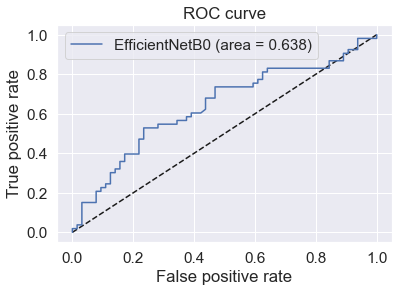

Confusion matrix without normalization
[[ 0 64]
 [ 0 53]]
 


<Figure size 432x288 with 0 Axes>

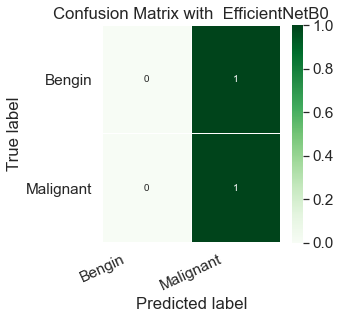

In [68]:
y_pred_cnn = model.predict(Res_XX_test) 
print(y_pred_cnn.shape)

rounded_predictions=[]
for i in range(len(y_pred_cnn)):
    A=[round(i) for i in y_pred_cnn[i]]
    rounded_predictions.append(A)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred_cnn)

                          
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='EfficientNetB0 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


    
print("Confusion matrix without normalization")
print(confusion_matrix(y_true=yy_test, y_pred=rounded_predictions))


matrix=confusion_matrix(y_true=yy_test, y_pred=rounded_predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)

print(' ')

# Build the plot
plt.figure(3)

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Bengin', 'Malignant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#plt.title('Confusion Matrix for neural network with equalized data')
plt.title('Confusion Matrix with  EfficientNetB0')
plt.show()


